In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Some data

In [3]:
observations = 1_000_000

x, y = np.random.rand(observations), np.random.rand(observations)
ids = np.repeat(np.arange(observations//10), 10)
df = pd.DataFrame({'x': x, 'y':y, 'id':ids})

Check if polygon (red) contains these points

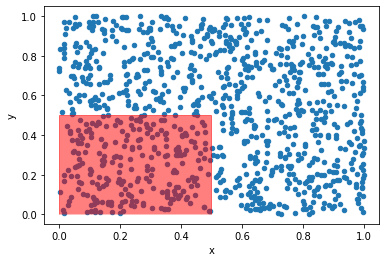

In [4]:
from matplotlib.patches import Polygon

ax = plt.gca()
df.sample(1000).plot.scatter(x='x', y='y', ax=ax)

polygon_coords = np.array([[0.0, 0.0], [0.0, 0.5], [0.5, 0.5], [0.5, 0.0]])

p = Polygon(polygon_coords, closed=False, fc='red', alpha=.5, ec='red')
ax.add_patch(p)

In [5]:
%load_ext memory_profiler

ModuleNotFoundError: No module named 'memory_profiler'

## Rustgeos

In [6]:
import rustgeos
result_rust = rustgeos.contains(polygon_coords, df.x.values, df.y.values)

In [7]:
%%timeit
rustgeos.contains(polygon_coords, df.x.values, df.y.values)

10 loops, best of 5: 35.6 ms per loop


In [45]:
%%memit
rustgeos.contains(polygon_coords, df.x.values, df.y.values)

peak memory: 490.48 MiB, increment: 0.00 MiB


## Shapely vectorized

In [36]:
from shapely.geometry import Polygon, LineString
from shapely.prepared import prep
from shapely.vectorized import contains

In [24]:
%%timeit
zone = Polygon(polygon_coords)
contains(prep(zone), df.x.values, df.y.values)

133 ms ± 3.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
result_shapely = contains(prep(zone), df.x.values, df.y.values)

In [12]:
%%memit
zone = Polygon(polygon_coords)
contains(prep(zone), df.x.values, df.y.values)

peak memory: 165.21 MiB, increment: 0.00 MiB


## PyGeos

In [38]:
from pygeos.predicates import contains
from pygeos.creation import box, points
from pygeos.creation import Geometry

In [27]:
%%timeit

geoms = points(df.x.values, df.y.values)

xy_with_space = [' '.join([str(x) for x in a]) for a in polygon_coords]
xy_closed = xy_with_space + xy_with_space[:1]
coords_string = ', '.join(xy_closed).replace('[', '(').replace(']', ')')
poly = Geometry(f"POLYGON(({coords_string}))")

contains(poly, geoms)

1.11 s ± 27.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
result_pygeos = contains(poly, geoms)

In [16]:
%%memit

geoms = points(df.x.values, df.y.values)

xy_with_space = [' '.join([str(x) for x in a]) for a in polygon_coords]
xy_closed = xy_with_space + xy_with_space[:1]
coords_string = ', '.join(xy_closed).replace('[', '(').replace(']', ')')
poly = Geometry(f"POLYGON(({coords_string}))")

contains(poly, geoms)

peak memory: 346.66 MiB, increment: 131.85 MiB


## Just to be sure

In [40]:
np.testing.assert_equal(result_rust, result_shapely)
np.testing.assert_equal(result_rust, result_pygeos)

## Performance comparison

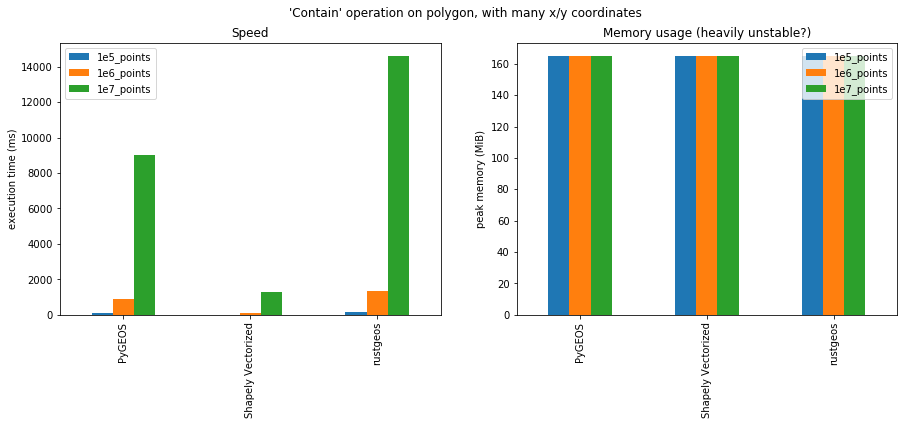

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

mem_stats = pd.DataFrame({'1e5_points': [165, 165, 165],
                          '1e6_points': [165, 165, 165],
                          '1e7_points': [165, 165, 165]}, 
                         index=['PyGEOS', 'Shapely Vectorized', 'rustgeos'])


cpu_stats = pd.DataFrame({'1e5_points': [120, 12, 140],
                          '1e6_points': [867, 108, 1360],
                          '1e7_points': [9010, 1290, 14600]}, 
                         index=['PyGEOS', 'Shapely Vectorized', 'rustgeos'])

cpu_stats.plot.bar(ax=axes[0])
axes[0].set_title("Speed")
axes[0].set_ylabel('execution time (ms)')

mem_stats.plot.bar(ax=axes[1])
axes[1].set_title("Memory usage (heavily unstable?)")
axes[1].set_ylabel('peak memory (MiB)')


fig.suptitle("'Contain' operation on polygon, with many x/y coordinates");